In [59]:
!pip install -U plotly
!pip install jupyter-dash
!pip install Dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

import folium
from folium.plugins import HeatMap

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from dash import Dash

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [61]:
# Fazer o input do Dataset
from google.colab import files
uploaded = files.upload()

Saving AluguelCarros.csv to AluguelCarros (7).csv


mkdir: cannot create directory ‘assets’: File exists
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fuelType            5776 non-null   object 
 1   rating              5350 non-null   float64
 2   renterTripsTaken    5851 non-null   int64  
 3   reviewCount         5851 non-null   int64  
 4   location.city       5851 non-null   object 
 5   location.country    5851 non-null   object 
 6   location.latitude   5851 non-null   float64
 7   location.longitude  5851 non-null   float64
 8   location.state      5851 non-null   object 
 9   owner.id            5851 non-null   int64  
 10  rate.daily          5851 non-null   int64  
 11  vehicle.make        5851 non-null   object 
 12  vehicle.model       5851 non-null   object 
 13  vehicle.type        5851 non-null   object 
 14  vehicle.year        5851 non-null   int64  
dtypes:

<ipython-input-62-842ddcda4571>:54: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



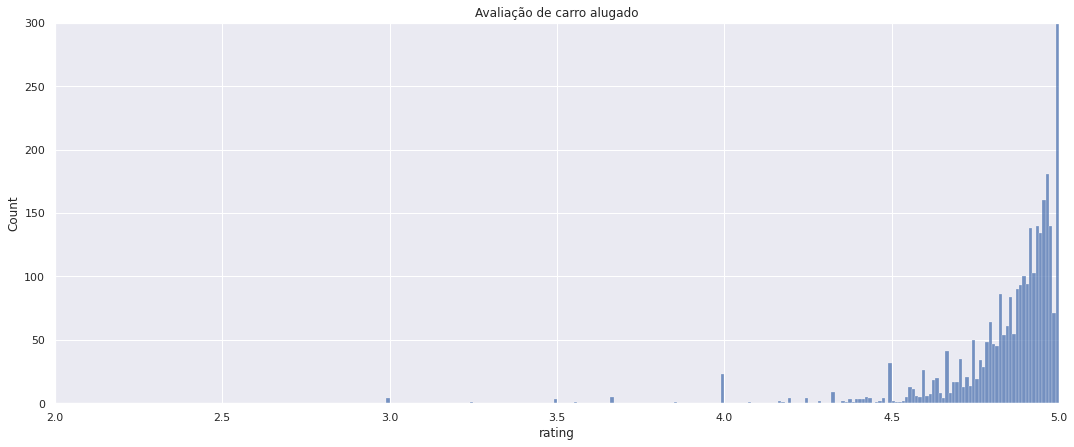

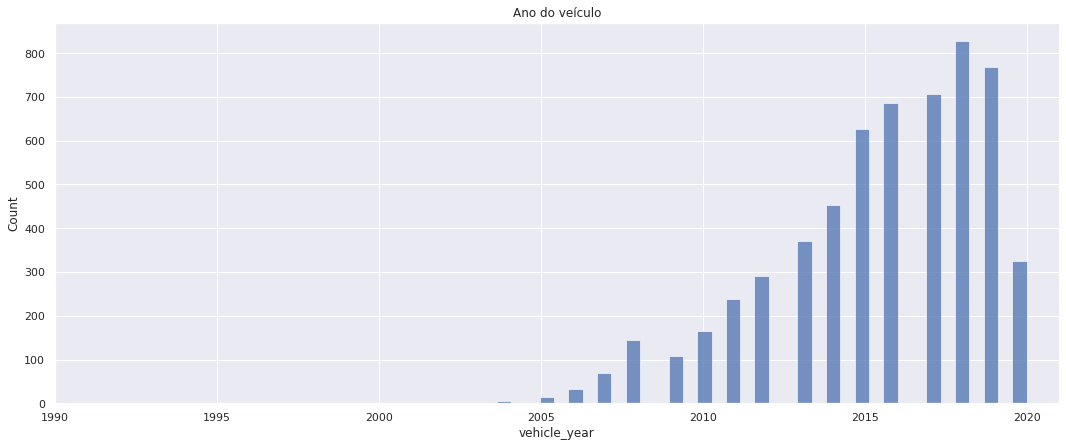

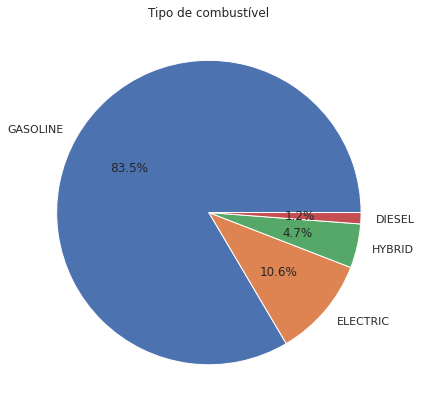

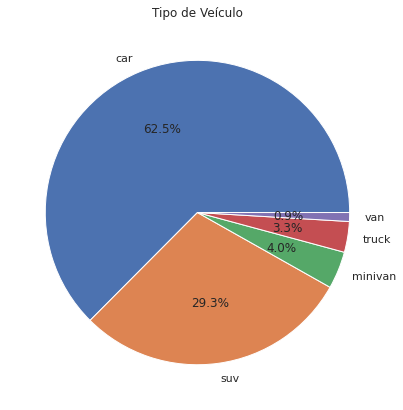

In [62]:
!mkdir assets

data=pd.read_csv('AluguelCarros.csv')

# Dar uma olhada nas cinco primeiras linhas usando o método head() do DataFrame
data.head()

# Obter uma descrição rápida dos dados, em particular o número total de linhas, 
# o tipo de cada atributo e o número de valores não nulos
data.info()

# Descobrir quais categorias existem e quantos distritos pertencem a cada categoria 
data["fuelType"].value_counts()


data["location.country"].value_counts()

# Como os dados são coletados nos EUA, é melhor excluir esta coluna
data.drop("location.country", axis=1, inplace=True)

# O método describe() mostra um resumo dos atributos numéricos
data.describe()

# Obter o valor do número de categorias
print("Number of Categories in: ")
for ColName in data[['fuelType','location.city','location.state','vehicle.make','vehicle.model','vehicle.year']]:
    print("{} = {}".format(ColName,len(data[ColName].unique())))


median=data["rating"].median()
data["rating"].fillna(median, inplace=True)

data.info()

# A maioria do tipo de combustível do carro é a gasolina. 
# Vamos preencher os valores que faltam com GASOLINA.
data1 = data.replace(np.nan, 'GASOLINE', regex=True)

data1 = data1.rename(columns={'location.latitude': 'latitude', 'location.longitude': 'longitude',
                             'rate.daily': 'rate_daily','vehicle.year': 'vehicle_year'})
data1.head()


# Plotando os dados em um mapa com Folium
center = [35.582889, -99.632773]  #data.describe(mean)
m = folium.Map([data1.latitude.mean(), data1.longitude.mean()], zoom_start=4,center=center)
for index, row in data1.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=row['renterTripsTaken']/10,
                        fill_color="#3db7e4", 
                       ).add_to(m)
    
points = data1[['latitude', 'longitude']].values
m.add_children(HeatMap(points, radius=15)) # plot heatmap
m.save('map.html')
m


# Histograma de classificação de carros alugados
f, ax = plt.subplots(figsize=(18, 7))
sns.histplot(data=data1, x="rating", binwidth=.01)
ax.set_ylim(0,300)
ax.set_xlim(2,5)
plt.title('Avaliação de carro alugado')
plt.savefig('assets/Rental_Car_Rating.png', bbox_inches='tight')
plt.show()

# Histograma do ano do veículo
f, ax = plt.subplots(figsize=(18, 7))
sns.histplot(data=data1, x="vehicle_year")
ax.set_xlim(1990,2021)
plt.title('Ano do veículo')
plt.savefig('assets/vehicle_year.png', bbox_inches='tight')
plt.show()


labels=data1['fuelType'].value_counts().index
values=data1['fuelType'].value_counts().values
# Visualização
plt.figure(figsize=(7,7))
plt.pie(values ,labels = labels ,autopct='%1.1f%%')
plt.title('Tipo de combustível')
plt.savefig('assets/Fuel_Type.png', bbox_inches='tight')
plt.show()


labels=data1['vehicle.type'].value_counts().index
values=data1['vehicle.type'].value_counts().values
# Visualização
plt.figure(figsize=(7,7))
plt.pie(values ,labels = labels ,autopct='%1.1f%%')
plt.title('Tipo de Veículo')
plt.savefig('assets/Vehicle_Type.png', bbox_inches='tight')
plt.show()


# Califórnia, Flórida e Texas são os três primeiros estados por clara diferença do resto dos estados

# Marca e modelo dos carros mais alugados
data_make_model = data1.groupby(['vehicle.make', 'vehicle.model']).size().reset_index()
data_make_model.rename(columns = {0:'model_count'}, inplace=True)
data_make_model['make_count'] = data_make_model['vehicle.make'].apply(
    lambda x : data_make_model[data_make_model['vehicle.make'] == x]['model_count'].sum())
data_make_model.sort_values(by = 'make_count', ascending=False, inplace=True)
fig =px.scatter(data_make_model[data_make_model['make_count'] >45],
             x = 'vehicle.make', y='model_count', color = 'vehicle.model',width=1100, height=700,
                title='Marca e modelo dos carros mais alugados')
fig.show()


fig.update_layout(barmode='group')

In [69]:
app = JupyterDash(__name__)
app.layout = html.Div(children=[
    html.H3('Tema do projeto', style={'fontFamily': 'Arial'}),
    html.Div(html.P("O tema escolhido busca trazer um conjunto de dados de 5.851 carros alugados." +
     " O conteúdo é adquirido durante o período de julho de 2020 para as principais cidades dos EUA" +
      " e é possivel verificar marca, modelo, ano, tarifa, local e tipo de combustível.", style={'fontFamily': 'Arial'})),

    html.Br(),

    html.H3('Link GitHub do projeto', style={'fontFamily': 'Arial'}),
    html.P('https://github.com/JulioSpanholi8/aluguel-carros-data-analysis', style={'fontFamily': 'Arial'}),

    html.H3('Dataset utilizado', style={'fontFamily': 'Arial'}),
    html.Div(html.P("O dataset utilizado conta com um conjunto de dados de 5.851 carros alugados durante o preríodo de julho de 2020 " +
     "para as principais cidades dos EUA, este dataset possui como informações 15 atributos: " +
     "tipo de combustível, classificação, viagens feitas pelo locatário, contagem de avaliações, cidade, país, longitude, latitude, estado, " +
     "ID do proprietário, tarifa diária, marca do veículo, modelo do veículo, tipo do veículo e ano do veículo. " +
      "Após a realizar uma análise algumas das respostas que este conjunto de dados pode ajudar a desvendar são: " +
      "quais marcas e modelos de carros são populares e em quais cidades; " +
       "qual é a tarifa típica do aluguel de carros em várias grandes cidades; " + 
       "dados foram apresentados em um mapa, mostrando onde fica o estacionamento, com raio de pontos baseado no número de viagens realizadas; "+
        "os usuários também podem explorar se as classificações nos sites têm alguma correlação ou parecem suspeitas, já que a maioria está próxima de 5 classificações. " +
         "Além disso verificar quais marcas e modelos estão em alta no mercado.", style={'fontFamily': 'Arial', 'textJustify': 'inter-word'})),

    html.Br(),
    html.Br(),

    html.Div([
      html.H4("Histograma do ano do veículo", style={'fontFamily': 'Arial'}),
      html.Img(src='assets/vehicle_year.png', style={'marginRight': '32px'}),

      html.H4("Histograma de classificação de carros alugados", style={'fontFamily': 'Arial'}),
      html.Img(src='assets/Rental_Car_Rating.png', style={'marginRight': '32px'}),

      html.Img(src='assets/Fuel_Type.png', style={'marginRight': '32px'}),
      html.Img(src='assets/Vehicle_Type.png', style={'marginRight': '32px'}),
      html.Br(),
      html.Br(),
      html.Br(),
      html.Br(),
    ]),

    html.Br(),
    html.Br(),

    html.H4("Localização dos estacionamentos, com raio de pontos baseado no número de viagens realizadas:", style={'fontFamily': 'Arial'}),
    html.Iframe(id='map', srcDoc=open('map.html', 'r').read(), width='100%', height='600'),
])

# Run app and display result inline in the notebook
app.run_server(mode='external', debug=True)

Dash app running on:


<IPython.core.display.Javascript object>